# Cooke triplet

Let's try to model a Cooke Triplet, working from this screenshot from an old patent, taken from Wikipedia:

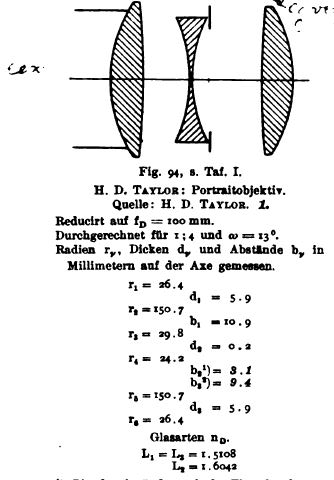


First, let's define the surfaces as spherical, using the radius of curvatures provided. Lenses diameters are not given, I'm gonna guess 30 and 25 to start with:

In [ ]:
import torch
import torchlensmaker as tlm

d1, d2 = 30, 25

r1 = tlm.Sphere(d1, 26.4)
r2 = tlm.Sphere(d1, -150.7)
r3 = tlm.Sphere(d2, -29.8)
r4 = tlm.Sphere(d2, 24.2)
r5 = tlm.Sphere(d1, 150.7)
r6 = tlm.Sphere(d1, -26.4)

Next, we can define the material models for the lenses. In a Cooke Triplet, two materials are used, with the center one being denser to refract light more.

In [ ]:
material1 = tlm.NonDispersiveMaterial(1.5108)
material2 = tlm.NonDispersiveMaterial(1.6042)

L1 = tlm.Lens(r1, r2, material=material1, inner_thickness=5.9)
L2 = tlm.Lens(r3, r4, material=material2, inner_thickness=0.2)
L3 = tlm.Lens(r5, r6, material=material1, inner_thickness=5.9)

The distance between the last lens and the image plane is unclear from the document. Let's guess an inital value of 85, but wrap it in `tlm.parameter()`, so we can optimize it later.

In [ ]:
focal = tlm.parameter(85)

Finally, we can define our optical sequence model, by stacking everying together in a `tlm.Sequential` object.

In [ ]:
optics = tlm.Sequential(
    tlm.ObjectAtInfinity(15, 25),
    L1,
    tlm.Gap(10.9),
    L2,
    tlm.Gap(3.1),
    tlm.Aperture(18),
    tlm.Gap(9.4),
    L3,
    tlm.Gap(focal),
    tlm.ImagePlane(65),
)

And we can view the system in 2D with `tlm.show2d()`. Note that if don't specify sampling parameters, it will try to use sensible ones by default.

In [ ]:
tlm.show2d(optics)

In [ ]:
sampling = {"base":1000, "object": 4}
tlm.show3d(optics, sampling)
f, _ = tlm.spot_diagram(optics, sampling=sampling, row="object", figsize=(12, 12))

Looking at the spot diagram, we can see that rays are not focused at all. We can now optimize the parameter we created before, to try to find the best value for the image plane distance.

In [ ]:
import torch.optim as optim

tlm.optimize(optics,
             dim=2,
             optimizer = optim.Adam(optics.parameters(), lr=1e-1),
             sampling = {"base": 5, "object": 10, "wavelength": 3},
             num_iter=50,
).plot()

print("Final parameter value:", focal.item())

In [ ]:
f, _ = tlm.spot_diagram(optics, sampling=sampling, row="object", figsize=(12, 12))